Notes: this code does contain bugs

# Import Libraries

In [ ]:
#import required libraries
import collections
import jax
import jax.numpy as jnp
import numpy as np
import math
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Create Target Policy


In [ ]:
# set amount of states and discount
state_amount = 10 #50
discount = 0.9

# create an action list for each state using given actions
actions = {}
action_list = [-1, 0, 1] #[-4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
for x in range(state_amount):
  actions[x] = []
  for a in action_list:
    if (x + a >= 0 and x + a < state_amount):
      actions[x].append(a)

# randomly set a reward for each state
R = np.zeros((state_amount, state_amount))
for s1 in range(len(R)):
  for s2 in range(len(R[0])):
    R[s1][s2] = 0.  #random.random() * 100
    # if (s1 < state_amount/2):
    #   R[s1][s2] = 5.
    # else:
    #   R[s1][s2] = 1.

# calculate probability of going from one state to another for each (s1, s2) pair
P = np.zeros((state_amount, state_amount))
for s1 in range(len(P)):
  for s2 in range(len(P[s1])):
    if (s1 == s2):
      P[s1][s2] = 1


# use previous P, discount and R to calculate target policy
I = np.identity(len(P))
Q = np.dot(np.linalg.inv(np.subtract(I,(discount * P))),  R)
print(Q)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


# Create Behavior Policy

In [ ]:
# calculate probability of going from one state to another for each (s1, s2) pair
P = np.zeros((state_amount, state_amount))
for s1 in range(len(P)):
  for s2 in range(len(P[s1])):
    for a in action_list:
      if (s1 + a == s2):
        P[s1][s2] = 1 / len(actions[s1])

# Collect Samples

In [ ]:
def collect_samples(num_epochs, Q_est, R, discount, start_state):
  """ 
  Args:
    num_epochs: the number of (s, a) pairs generated, int
    state_state: the initial state for sample collection
    Q_est: the current behavior policy
    R: the rewards for each state
    discount: the discount factor

  Returns:
    all_states: a list of all generated states
    all_values: a list of values for the taken (s, a) pairs
    all_rewards: a list of rewards for taken (s, a) pairs
    all_actions: a list of all generated actions
  """

  # initialize all return arrays
  all_values = []
  all_rewards = []
  all_states = []
  all_actions = []

  # set first state to given first state
  s1 = start_state
  #s1 = random.choice(range(len(Q_est)))
  
  # collect specified amount of samples
  for i in range(num_epochs):
      # add current state to all states
      all_states.append(s1)

      # take a random action and calculate next state
      a = random.choice(actions[s1])
      s2 = s1 + a

      # update return arrays to add the taken step
      all_values.append(Q_est[s1][s2])
      all_rewards.append(R[s1][s2])
      all_actions.append(a)
      
      # move on to the next state
      s1 = s2

  # add the last state to state list
  all_states.append(s1)

  # return the collected data
  return all_states, all_values, all_rewards, all_actions

# Calculate Rhos

In [ ]:
# calculate the rhos using target and behavior policy
def calc_rhos(all_states, all_actions, Q, Q_est):
  """
  Args:
    all_states: a list of all the collected states
    all_actions: a list of the corresponding collected actions
    Q: the target policy
    Q_est: the current behavior policy

  Returns:
    rho_t: a list of rhos at time t
    log_pi_a_t: a list of the target policy logits at time t
  """

  log_pi_a_t = []
  log_mu_a_t = []
  rho_t = []
    
  # go through states and calculate probabilities
  for t in range(len(all_states)-1):
    # keep track of future state-actions
    s = all_states[t]
    next_s = all_states[t+1]
    a = all_actions[t]

    total_val = []
    total_val_est = []
    
    # calculate total possible q values
    for a2 in actions[s]:
        s2 = s + a2
        total_val.append(Q[s][s2])
        total_val_est.append(Q_est[s][s2])

    # calculate q value we took
    for a_num in range(len(actions[s])):
        if (actions[s][a_num] == a):
            break

    # use that to make a probability distribution
    log_pi_a_t.append(jax.nn.log_softmax(np.asarray(total_val))[a_num])
    log_mu_a_t.append(jax.nn.log_softmax(np.asarray(total_val_est))[a_num])

  # take difference between target and behavior for rhos
  rho_t = jnp.exp(np.asarray(log_pi_a_t) - np.asarray(log_mu_a_t))

  return rho_t, log_pi_a_t

# Update Q function

In [ ]:
def update_Q(bootstrap_horizon, learning_rate_amount, discount, Q_est, rho, c, all_rewards, all_states, visited):
  """
  Args:
    bootstrap_horizon: how many steps to look ahead, int
    learning_rate_amount: learning rate, [0,1]
    discount: how much to discount future states, [0,1]
    Q_est: current estimate of Q
    rho: rho ratios
    c: c ratios
    all_rewards: rewards from sample collection
    all_states: states from sample collection
    visited: which Q estimates have been updated so far
  """
  # set old_Q to current Q estimate
  old_Q = Q_est

  # loop over all the states
  num_iters = len(all_states) - bootstrap_horizon
  for k in range(num_iters - 1):
    # keep track of relevant states
    s1 = all_states[k]
    s2 = all_states[k+1]
    s3 = all_states[k+2]      
     
    change = {}
    sum = 0
    total = 0
    all_sums = []
    # calculate sum for future steps
    for sum_num in range(k, k + bootstrap_horizon - 1):
      i = sum_num

      # calculated discounted future step
      discounted_Q = discount * rho[i+1] * old_Q[all_states[i+1]][all_states[i+2]]
      #calculate change needed
      change[(k, i)] = all_rewards[i] + discounted_Q - old_Q[all_states[i]][all_states[i+1]]

      product = 0
      all_products = []
      for product_num in range(k+1, sum_num):
        # calculate all products
        all_products.append(product)
        if product == 0:
          product = 1
        product1 = product
        product = c[product_num] * product
        
      # combine into sum and keep track of for update
      sum += (discount ** (sum_num-k)) * product * change[(k, i)]
      all_sums.append((discount ** (sum_num-k)) * product)

    # use sum to update old Q estimate
    updated_Q_value = old_Q[s1][s2] + learning_rate_amount * sum
    old_Q[s1][s2] = updated_Q_value

    # state has now been updated
    visited[s1][s2] = 1.
    
  return old_Q, visited

# Run All

In [ ]:
#reorganize Qs
def reorder(Q, Q_est):
  """
  Args:
    Q: target policy
    Q_est: behavior policy

  Returns:
    reordered_est: reshaped behavior policy
    reordered_exact: reshaped target policy
  """

  reordered_est = []
  reordered_exact = []

  # go through every s-a pair and change it into the matrix shape we need
  for s1 in range(len(Q)):
    for s2 in range(len(Q[s1])):
      for a in action_list:
        # only keep track of possible combinations
        if (s1 + a == s2):
          # create matrix for Q estimate and actual Q function
          reordered_est.append(Q_est[s1][s2])
          reordered_exact.append(Q[s1][s2])

  # calculate distance between Q functions
  dist = np.linalg.norm(np.asarray(reordered_exact)-np.asarray(reordered_est))
  return dist, reordered_est, reordered_exact

In [ ]:
# create empty Q estimate and visited matrix
Q_est = np.full((state_amount, state_amount), 0.25)
visited = np.zeros((state_amount, state_amount))

# set necessary vars
num_repeats = 1000
bootstrap_horizon = 5
learning_rate_amount = 0.05
discount = 0.9
num_samples = 10

all_dist = []
all_reordered = []
all_ests = []

# loop over every state a set amount of times
for n in tqdm(range(num_repeats)):
  for state in range(state_amount):
    # collect samples
    all_states, all_values, all_rewards, all_actions = collect_samples(num_samples, Q_est, R, discount, state)
    # update IS ratios based on samples
    rho_t, log_pi_a_t = calc_rhos(all_states, all_actions, Q, Q_est)
    # calculate new Q estimate
    Q_est, visited = update_Q(bootstrap_horizon, learning_rate_amount, discount, Q_est, rho_t, rho_t, all_rewards, all_states, visited)
    # keep track of relevant data
    all_ests.append(Q_est)
    dist, reordered_est, reordered_exact = reorder(Q, Q_est)
    all_dist.append(dist)
    all_reordered.append(reordered_est)


100%|██████████| 1000/1000 [19:04<00:00,  1.14s/it]


# Test

28


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


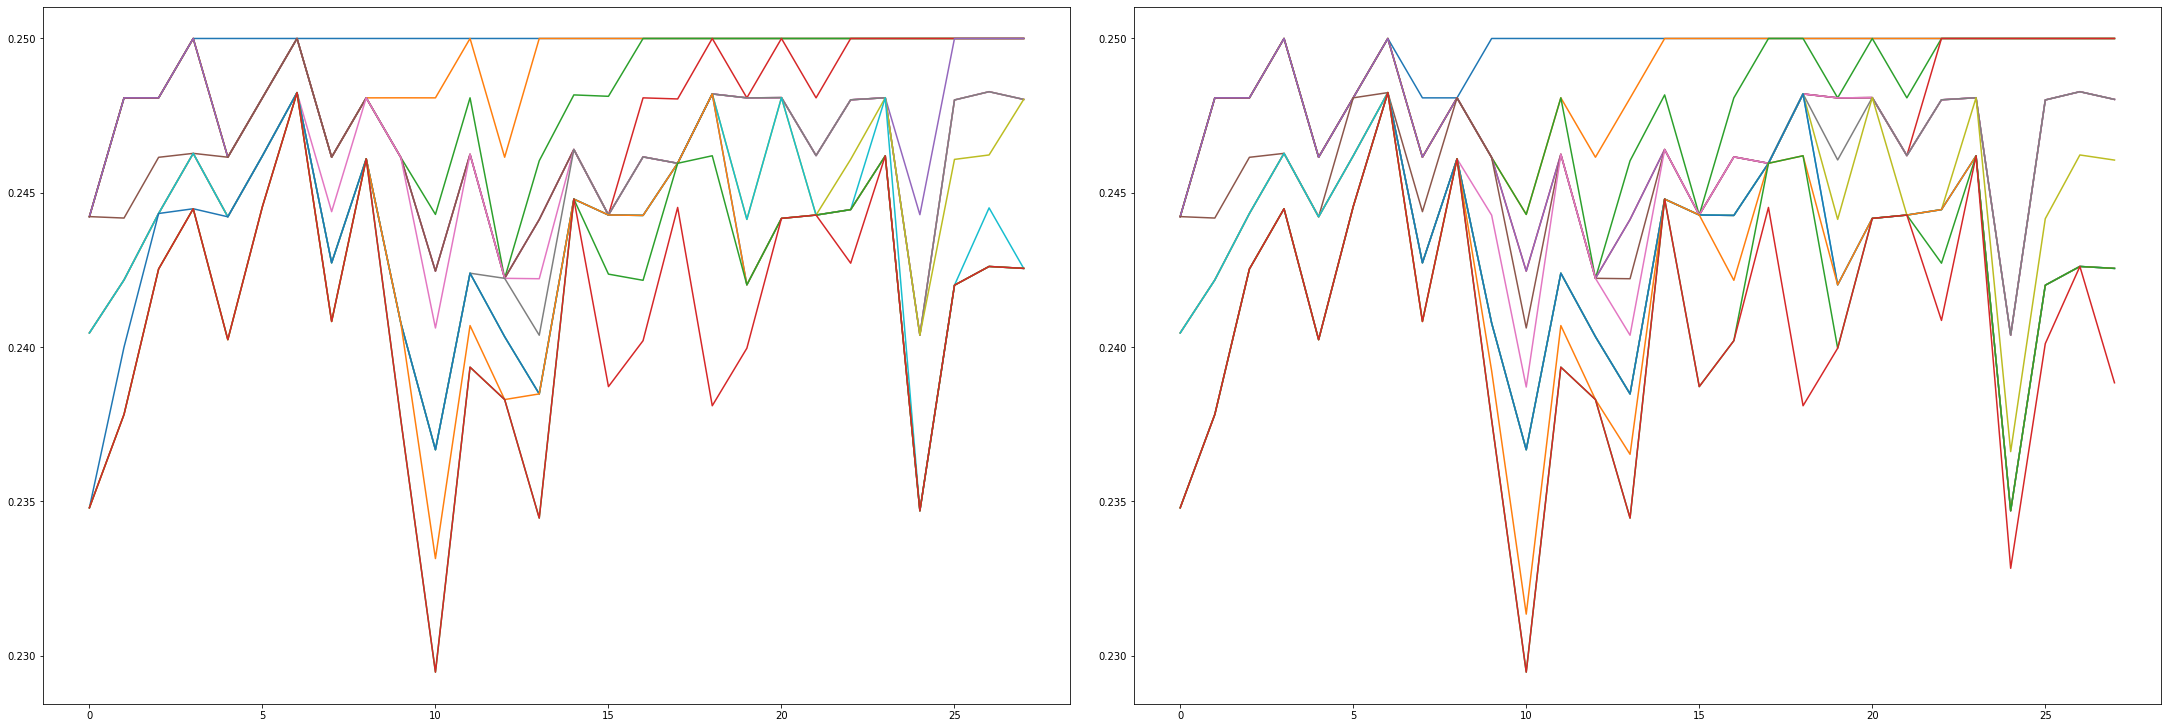

In [ ]:
# create a plot layout for grids
fig = plt.figure(constrained_layout=True)
ax = fig.add_gridspec(1, 2)
fig.set_figheight(10)
fig.set_figwidth(30)

# create a time dimension with +1 for each update
time = []
print(len(all_reordered[0]))
for t in range(len(all_reordered[0])):
    time.append(t)
    
# graph Q estimate convergence
for s in range(len(all_reordered[0])):  
  if (s%2 == 0):
    ax1 = fig.add_subplot(ax[0, 0])
  else:
    ax1 = fig.add_subplot(ax[0, 1])

  ax1.plot(time, all_reordered[:][s])


In [ ]:
# create time dimension
all_t = []
for t in range(state_amount*num_repeats):
  all_t.append(t)

# plot difference between Q and Q estimate over time
plt.plot(all_t, all_dist)

plt.xlabel('Number of Runs')
plt.ylabel("Distance between actual and estimate Q")
plt.title("Algorithm Comparison")
  